# 一、项目描述

利用IMDB电影评论数据做文本分类项目，分别利用FNN、TextCNN、TextRNN、TextRCNN、GRU+Attention和Transformer实现文本分类。

实验目标描述：

- 1、探究使用GloVe词向量对文本分类效果的影响：使用GloVe词向量（freeze与unfreeze），随机初始化词向量；
- 2、探究不同种类和数量的卷积核对TextCNN性能的影响

# 二、数据预处理

分词器：

In [1]:
import nltk
import string
%matplotlib inline
from nltk import word_tokenize
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

enstop = stopwords.words('english')
punct = string.punctuation

def tokenizer(sent):
    sent = sent.lower()
    tmp = word_tokenize(sent)
    res = []
    for word in tmp:
        if word not in enstop and word not in punct:
            res.append(word)
    return res

IMDB数据读取：

In [2]:
import torch
import torch.nn as nn
from torchtext import data
from torchtext import vocab

text_field = data.Field(tokenize=tokenizer, lower=True, include_lengths=True,
                        fix_length=256)
label_field = data.Field(sequential=False, use_vocab=False, dtype=torch.long)
train, valid, test = data.TabularDataset.splits(path='',
                                                train='imdb-train.csv',
                                                validation='imdb-valid.csv',
                                                test='imdb-test.csv',
                                                format='csv', skip_header=True,
                                                fields=[('sentence', text_field), ('label', label_field)])

读取GloVe词向量：

In [3]:
vec = vocab.Vectors(name='glove.6B.300d.txt')
text_field.build_vocab(train, valid, test, max_size=250000, vectors=vec,
                       unk_init=torch.Tensor.normal_)
label_field.build_vocab(train, valid, test)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iter, valid_iter, test_iter = data.BucketIterator.splits((train, valid, test), batch_sizes=(64, 64, 64),
                                                               sort_key=lambda x: len(x.sentence),
                                                               sort_within_batch=True,
                                                               repeat=False, shuffle=True,
                                                               device=device)

# 三、模型训练函数

In [5]:
def train_fun(model, train_iter, dev_iter, num_epoch, opt, criterion, eva,
              out_model_file):
    model.train()
    loss_list = []
    dev_acc = []
    best_dev_acc = 0.
    for epoch in range(num_epoch):
        total_loss = 0.
        for batch in train_iter:
            output = model(batch.sentence)
            loss = criterion(output, batch.label)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()
        loss_list.append(total_loss)
        dev_acc.append(eva(model, dev_iter))
        print(f"Epoch: {epoch+1}/{num_epoch}. Total loss: {total_loss:.3f}. Validation Set Acc: {dev_acc[-1]:.3%}.")
        if dev_acc[-1] > best_dev_acc:
            best_dev_acc = dev_acc[-1]
            torch.save(model.state_dict(), out_model_file)
    return loss_list, dev_acc

# 四、模型评价函数

In [6]:
def eva(model, data_iter):
    correct, count = 0, 0
    with torch.no_grad():
        for batch in data_iter:
            pred = model(batch.sentence)
            pred = torch.argmax(pred, dim=-1)
            correct += (pred == batch.label).sum().item()
            count += len(pred)
    return correct / count

# 五、分类器1: TextFNN

## 5.1 模型

属于最简单的分类器：利用三层前馈神经网络实现初步的文本分类功能。

In [53]:
import torch.nn as nn

class FNN(nn.Module):
    def __init__(self, embedding_dim, seq_len, hidden_size1, hidden_size2,
                 out_dim, pretrained_embed, dropout_rate=0.1, vocab_size=None,
                 freeze=True, random_embed=False):
        super(FNN, self).__init__()
        if random_embed:
            self.embed = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embed = nn.Embedding.from_pretrained(pretrained_embed, freeze=freeze)
        
        self.proj = nn.Sequential(
                nn.Dropout(p=dropout_rate),
                nn.Linear(embedding_dim * seq_len, hidden_size1),
                nn.ReLU(),
                nn.Dropout(p=dropout_rate),
                nn.Linear(hidden_size1, hidden_size2),
                nn.ReLU(),
                nn.Dropout(p=dropout_rate),
                nn.Linear(hidden_size2, out_dim)
            )
    
    def forward(self, x):
        x, _ = x # [seq, bs]
        embed_x = self.embed(x) # [seq, bs, embed]
        embed_x = embed_x.permute(1, 0, 2) # [bs, seq, embed]
        embed_x = embed_x.reshape(embed_x.shape[0], -1) # [bs, seq * embed]
        return self.proj(embed_x)

## 5.2 GloVe Freeze

In [40]:
# Hyperparameters
embedding_dim = 300
out_dim = 2
pretrained_embed = text_field.vocab.vectors
num_epoch = 20
lr = 0.001
seq_len = 256
hidden_size1 = 300
hidden_size2 = 300
out_model_file = 'textfnn.pt'

textfnn = FNN(embedding_dim, seq_len, hidden_size1, hidden_size2,
              out_dim, pretrained_embed).to(device)
opt = torch.optim.Adam(textfnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

print(f"Training begin!")
loss_list, dev_acc_list = train_fun(textfnn, train_iter, valid_iter, num_epoch, opt, criterion, eva,
                                    out_model_file)

Training begin!
Epoch: 1/20. Total loss: 213.268. Validation Set Acc: 78.720%.
Epoch: 2/20. Total loss: 122.816. Validation Set Acc: 77.780%.
Epoch: 3/20. Total loss: 57.800. Validation Set Acc: 76.880%.
Epoch: 4/20. Total loss: 30.819. Validation Set Acc: 77.100%.
Epoch: 5/20. Total loss: 24.789. Validation Set Acc: 75.660%.
Epoch: 6/20. Total loss: 18.073. Validation Set Acc: 76.540%.
Epoch: 7/20. Total loss: 11.421. Validation Set Acc: 75.840%.
Epoch: 8/20. Total loss: 12.699. Validation Set Acc: 76.300%.
Epoch: 9/20. Total loss: 9.551. Validation Set Acc: 76.140%.
Epoch: 10/20. Total loss: 10.772. Validation Set Acc: 76.260%.
Epoch: 11/20. Total loss: 9.883. Validation Set Acc: 76.320%.
Epoch: 12/20. Total loss: 7.934. Validation Set Acc: 76.580%.
Epoch: 13/20. Total loss: 10.096. Validation Set Acc: 76.320%.
Epoch: 14/20. Total loss: 9.462. Validation Set Acc: 75.660%.
Epoch: 15/20. Total loss: 7.632. Validation Set Acc: 75.600%.
Epoch: 16/20. Total loss: 10.839. Validation Set Ac

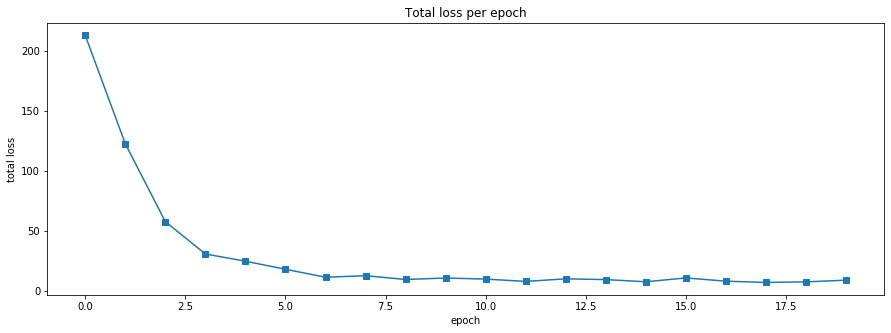

In [41]:
plt.figure(figsize=(15,5))
plt.plot(loss_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('total loss')
plt.title('Total loss per epoch')
plt.show()

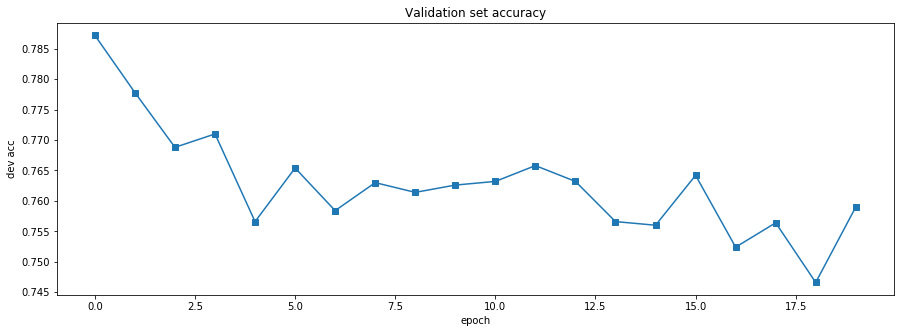

In [42]:
plt.figure(figsize=(15,5))
plt.plot(dev_acc_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('dev acc')
plt.title('Validation set accuracy')
plt.show()

我们可以看到第一个epoch的时候验证集的准确率最高。

In [50]:
epoch1_textfnn = FNN(embedding_dim, seq_len, hidden_size1, hidden_size2,
                     out_dim, pretrained_embed).to(device)
epoch1_textfnn.load_state_dict(torch.load('textfnn.pt'))
print(f"Test set acc: {eva(epoch1_textfnn, test_iter):.2%}")

Test set acc: 77.22%


## 5.3 GloVe Unfreeze

In [44]:
# Hyperparameters
embedding_dim = 300
out_dim = 2
pretrained_embed = text_field.vocab.vectors
num_epoch = 20
lr = 0.001
seq_len = 256
hidden_size1 = 300
hidden_size2 = 300
out_model_file = 'textfnn_unfreeze.pt'

textfnn = FNN(embedding_dim, seq_len, hidden_size1, hidden_size2,
              out_dim, pretrained_embed, freeze=False).to(device)
opt = torch.optim.Adam(textfnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

print(f"Training begin!")
loss_list, dev_acc_list = train_fun(textfnn, train_iter, valid_iter, num_epoch, opt, criterion, eva,
                                    out_model_file)

Training begin!
Epoch: 1/20. Total loss: 180.849. Validation Set Acc: 85.320%.
Epoch: 2/20. Total loss: 47.127. Validation Set Acc: 85.660%.
Epoch: 3/20. Total loss: 9.501. Validation Set Acc: 85.180%.
Epoch: 4/20. Total loss: 4.894. Validation Set Acc: 83.980%.
Epoch: 5/20. Total loss: 4.013. Validation Set Acc: 84.260%.
Epoch: 6/20. Total loss: 1.919. Validation Set Acc: 85.200%.
Epoch: 7/20. Total loss: 2.134. Validation Set Acc: 84.760%.
Epoch: 8/20. Total loss: 3.144. Validation Set Acc: 83.920%.
Epoch: 9/20. Total loss: 1.740. Validation Set Acc: 84.720%.
Epoch: 10/20. Total loss: 1.825. Validation Set Acc: 84.560%.
Epoch: 11/20. Total loss: 2.485. Validation Set Acc: 85.020%.
Epoch: 12/20. Total loss: 2.105. Validation Set Acc: 84.760%.
Epoch: 13/20. Total loss: 1.381. Validation Set Acc: 84.480%.
Epoch: 14/20. Total loss: 0.432. Validation Set Acc: 85.460%.
Epoch: 15/20. Total loss: 0.917. Validation Set Acc: 84.900%.
Epoch: 16/20. Total loss: 0.962. Validation Set Acc: 84.500%

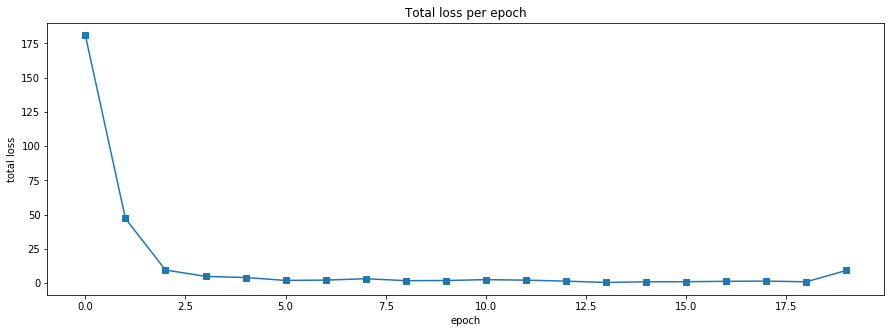

In [45]:
plt.figure(figsize=(15,5))
plt.plot(loss_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('total loss')
plt.title('Total loss per epoch')
plt.show()

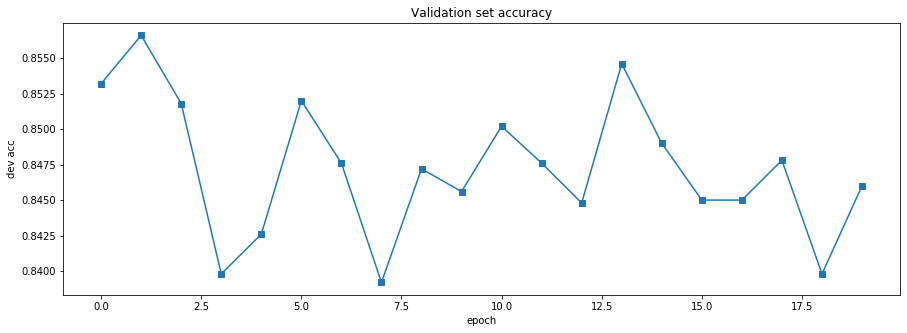

In [46]:
plt.figure(figsize=(15,5))
plt.plot(dev_acc_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('dev acc')
plt.title('Validation set accuracy')
plt.show()

我们可以看到第2个epoch的时候验证集的准确率最高。

In [49]:
epoch2_textfnn_unfreeze = FNN(embedding_dim, seq_len, hidden_size1, hidden_size2,
                              out_dim, pretrained_embed, freeze=False).to(device)
epoch2_textfnn_unfreeze.load_state_dict(torch.load('textfnn_unfreeze.pt'))
print(f"Test set acc: {eva(epoch2_textfnn_unfreeze, test_iter):.2%}")

Test set acc: 84.84%


# 5.4 随机初始化词向量

In [58]:
# Hyperparameters
embedding_dim = 300
out_dim = 2
pretrained_embed = text_field.vocab.vectors
vocab_size = len(text_field.vocab.itos)
num_epoch = 20
lr = 0.001
seq_len = 256
hidden_size1 = 300
hidden_size2 = 300
out_model_file = 'textfnn_random.pt'

textfnn_random = FNN(embedding_dim, seq_len, hidden_size1, hidden_size2,
                     out_dim, pretrained_embed, vocab_size=vocab_size, freeze=False,
                     random_embed=True).to(device)
opt = torch.optim.Adam(textfnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

print(f"Training begin!")
loss_list, dev_acc_list = train_fun(textfnn_random, train_iter, valid_iter, num_epoch, opt, criterion, eva,
                                    out_model_file)

Training begin!
Epoch: 1/20. Total loss: 271.868. Validation Set Acc: 49.920%.
Epoch: 2/20. Total loss: 272.040. Validation Set Acc: 50.200%.
Epoch: 3/20. Total loss: 271.893. Validation Set Acc: 50.120%.
Epoch: 4/20. Total loss: 271.998. Validation Set Acc: 49.920%.
Epoch: 5/20. Total loss: 271.838. Validation Set Acc: 50.220%.
Epoch: 6/20. Total loss: 271.932. Validation Set Acc: 50.100%.
Epoch: 7/20. Total loss: 272.003. Validation Set Acc: 50.360%.
Epoch: 8/20. Total loss: 271.969. Validation Set Acc: 49.380%.
Epoch: 9/20. Total loss: 271.746. Validation Set Acc: 49.480%.
Epoch: 10/20. Total loss: 271.801. Validation Set Acc: 49.880%.
Epoch: 11/20. Total loss: 271.755. Validation Set Acc: 50.280%.
Epoch: 12/20. Total loss: 271.939. Validation Set Acc: 50.560%.
Epoch: 13/20. Total loss: 272.018. Validation Set Acc: 50.400%.
Epoch: 14/20. Total loss: 271.784. Validation Set Acc: 49.320%.
Epoch: 15/20. Total loss: 271.900. Validation Set Acc: 49.440%.
Epoch: 16/20. Total loss: 272.051

由训练过程我们可以看到，如果随机初始化词向量的化，没有办法训练出一个有用的模型。

In [60]:
textfnn_random = FNN(embedding_dim, seq_len, hidden_size1, hidden_size2, 
                     out_dim, pretrained_embed, freeze=False, random_embed=True,
                     vocab_size=vocab_size).to(device)
textfnn_random.load_state_dict(torch.load('textfnn_random.pt'))
print(f"Test set acc: {eva(textfnn_random, test_iter):.2%}")

Test set acc: 49.90%


## 5.5 比较

在测试集上的准确率为：

- TextFNN+GloVe Freeze: 77.22%
- TextFNN+GloVe UnFreeze: 84.84%
- TextFNN+Random: 49.90%

# 六、分类器2:TextCNN

## 6.1 模型 

In [63]:
class CNN(nn.Module):
    def __init__(self, in_channels, out_channels, filter_list):
        super(CNN, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels, out_channels, kernel_size=fs)
            for fs in filter_list
        ])
        self.relu = nn.ReLU()
        self.init_params()
    
    def forward(self, x):
        return [self.relu(conv(x)) for conv in self.convs]
    
    def init_params(self):
        for m in self.convs:
            nn.init.kaiming_normal_(m.weight.data)
            nn.init.constant_(m.bias.data, 0)

In [62]:
class TextCNN(nn.Module):
    def __init__(self, embed_dim, pretrained_embed, filter_size, filter_channels,
                 out_dim, dropout_rate=0.1, vocab_size=None, freeze=True,
                 random_embed=False):
        super(TextCNN, self).__init__()
        if random_embed:
            self.embed = nn.Embedding(vocab_size, embed_dim)
        else:
            self.embed = nn.Embedding.from_pretrained(pretrained_embed, freeze=freeze)
        self.cnn = CNN(embed_dim, filter_channels, filter_size)
        self.proj = nn.Linear(len(filter_size) * filter_channels, out_dim)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.init_params()

    def init_params(self):
        nn.init.xavier_normal_(self.proj.weight.data)
        nn.init.constant_(self.proj.bias.data, 0)
    
    def forward(self, x):
        text, _ = x
        text = text.permute(1, 0) # [bs, seq_len]
        out = self.embed(text) # [bs, seq, emb]
        out = out.permute(0, 2, 1) # [bs, emb, seq]
        out = self.cnn(out) # [nf, bs, fc, -1]
        out = [torch.max_pool1d(x, x.shape[-1]).squeeze(2) for x in out] # [nf, bs, fc]
        out = self.dropout(torch.cat(out, dim=1)) 
        return self.proj(out)

## 6.2 GloVe Freeze

In [65]:
embed_dim = 300
pretrained_embed = text_field.vocab.vectors
filter_size = [1, 2, 3, 4, 5]
filter_channels = 300
freeze = True
vocab_size = len(text_field.vocab.stoi)
random_embed = False
out_dim = 2
dropout_rate = 0.2
num_epoch = 20
lr = 0.001
out_model_file = 'textcnn.pt'

print(f"Training begin!")
textcnn = TextCNN(embed_dim, pretrained_embed, filter_size, filter_channels,
                  out_dim, dropout_rate).to(device)
opt = torch.optim.Adam(textcnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss_list, dev_acc_list = train_fun(textcnn, train_iter, valid_iter, num_epoch, opt, criterion, eva,
                                    out_model_file)

Training begin!
Epoch: 1/20. Total loss: 185.155. Validation Set Acc: 85.520%.
Epoch: 2/20. Total loss: 89.285. Validation Set Acc: 85.360%.
Epoch: 3/20. Total loss: 59.007. Validation Set Acc: 84.120%.
Epoch: 4/20. Total loss: 33.973. Validation Set Acc: 86.960%.
Epoch: 5/20. Total loss: 18.768. Validation Set Acc: 86.560%.
Epoch: 6/20. Total loss: 13.561. Validation Set Acc: 87.380%.
Epoch: 7/20. Total loss: 13.036. Validation Set Acc: 87.140%.
Epoch: 8/20. Total loss: 10.914. Validation Set Acc: 86.340%.
Epoch: 9/20. Total loss: 10.840. Validation Set Acc: 86.000%.
Epoch: 10/20. Total loss: 16.465. Validation Set Acc: 86.500%.
Epoch: 11/20. Total loss: 19.992. Validation Set Acc: 85.500%.
Epoch: 12/20. Total loss: 20.194. Validation Set Acc: 86.580%.
Epoch: 13/20. Total loss: 15.867. Validation Set Acc: 86.140%.
Epoch: 14/20. Total loss: 9.383. Validation Set Acc: 86.800%.
Epoch: 15/20. Total loss: 10.313. Validation Set Acc: 86.360%.
Epoch: 16/20. Total loss: 12.330. Validation Set

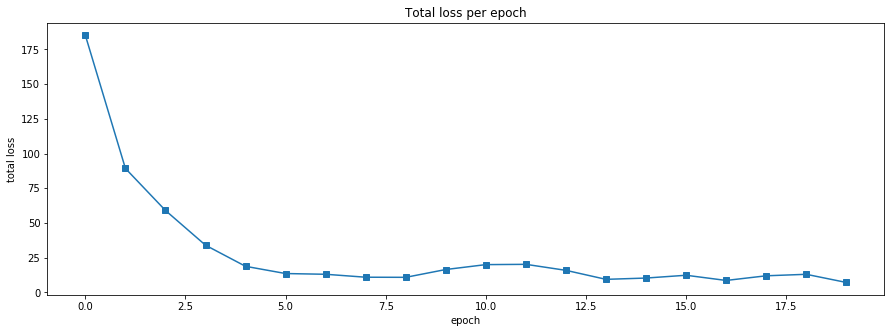

In [66]:
plt.figure(figsize=(15,5))
plt.plot(loss_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('total loss')
plt.title('Total loss per epoch')
plt.show()

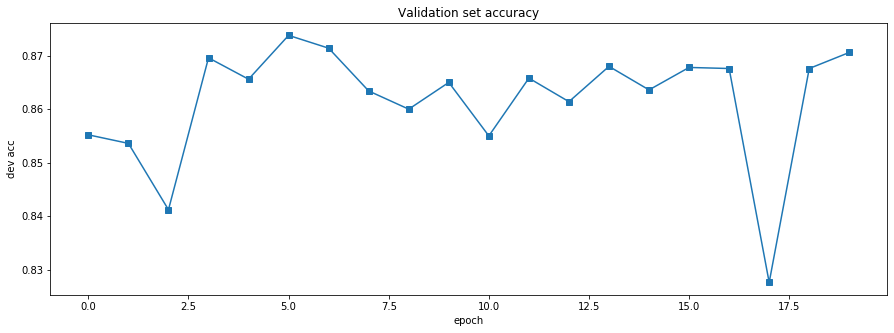

In [67]:
plt.figure(figsize=(15,5))
plt.plot(dev_acc_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('dev acc')
plt.title('Validation set accuracy')
plt.show()

In [68]:
textcnn_freeze = TextCNN(embed_dim, pretrained_embed, filter_size, filter_channels,
                         out_dim, dropout_rate).to(device)
textcnn_freeze.load_state_dict(torch.load('textcnn.pt'))
print(f"Test set acc: {eva(textcnn_freeze, test_iter):.2%}")

Test set acc: 87.12%


## 6.3 GloVe UnFreeze

In [69]:
embed_dim = 300
pretrained_embed = text_field.vocab.vectors
filter_size = [1, 2, 3, 4, 5]
filter_channels = 300
freeze = False
vocab_size = len(text_field.vocab.stoi)
random_embed = False
out_dim = 2
dropout_rate = 0.2
num_epoch = 20
lr = 0.001
out_model_file = 'textcnn_unfreeze.pt'

print(f"Training begin!")
textcnn_unfreeze = TextCNN(embed_dim, pretrained_embed, filter_size, filter_channels,
                           out_dim, dropout_rate, freeze=freeze).to(device)
opt = torch.optim.Adam(textcnn_unfreeze.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss_list, dev_acc_list = train_fun(textcnn_unfreeze, train_iter, valid_iter, num_epoch, opt, criterion, eva,
                                    out_model_file)

Training begin!
Epoch: 1/20. Total loss: 178.181. Validation Set Acc: 86.540%.
Epoch: 2/20. Total loss: 55.670. Validation Set Acc: 85.260%.
Epoch: 3/20. Total loss: 17.781. Validation Set Acc: 88.360%.
Epoch: 4/20. Total loss: 4.788. Validation Set Acc: 87.800%.
Epoch: 5/20. Total loss: 2.149. Validation Set Acc: 88.880%.
Epoch: 6/20. Total loss: 0.904. Validation Set Acc: 89.000%.
Epoch: 7/20. Total loss: 0.435. Validation Set Acc: 88.460%.
Epoch: 8/20. Total loss: 0.253. Validation Set Acc: 88.860%.
Epoch: 9/20. Total loss: 0.185. Validation Set Acc: 88.840%.
Epoch: 10/20. Total loss: 0.137. Validation Set Acc: 88.740%.
Epoch: 11/20. Total loss: 0.081. Validation Set Acc: 89.180%.
Epoch: 12/20. Total loss: 0.061. Validation Set Acc: 88.700%.
Epoch: 13/20. Total loss: 0.046. Validation Set Acc: 88.780%.
Epoch: 14/20. Total loss: 0.041. Validation Set Acc: 89.120%.
Epoch: 15/20. Total loss: 23.948. Validation Set Acc: 86.080%.
Epoch: 16/20. Total loss: 30.403. Validation Set Acc: 85.3

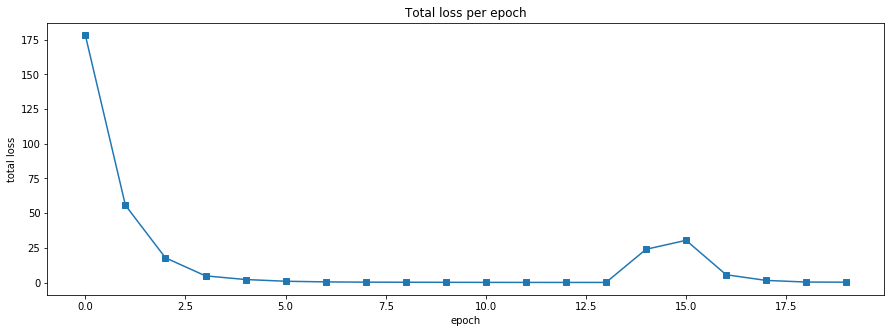

In [70]:
plt.figure(figsize=(15,5))
plt.plot(loss_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('total loss')
plt.title('Total loss per epoch')
plt.show()

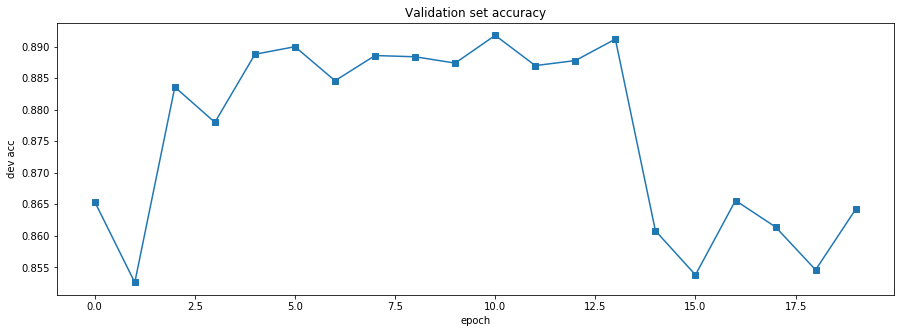

In [71]:
plt.figure(figsize=(15,5))
plt.plot(dev_acc_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('dev acc')
plt.title('Validation set accuracy')
plt.show()

In [72]:
textcnn_unfreeze = TextCNN(embed_dim, pretrained_embed, filter_size, filter_channels,
                         out_dim, dropout_rate, freeze=False).to(device)
textcnn_unfreeze.load_state_dict(torch.load('textcnn_unfreeze.pt'))
print(f"Test set acc: {eva(textcnn_unfreeze, test_iter):.2%}")

Test set acc: 88.40%


## 6.4 随机词向量

In [73]:
embed_dim = 300
pretrained_embed = text_field.vocab.vectors
filter_size = [1, 2, 3, 4, 5]
filter_channels = 300
freeze = False
vocab_size = len(text_field.vocab.stoi)
random_embed = True
out_dim = 2
dropout_rate = 0.2
num_epoch = 20
lr = 0.001
out_model_file = 'textcnn_random.pt'

print(f"Training begin!")
textcnn_random = TextCNN(embed_dim, pretrained_embed, filter_size, filter_channels,
                         out_dim, dropout_rate, freeze=freeze, random_embed=random_embed,
                         vocab_size=vocab_size).to(device)
opt = torch.optim.Adam(textcnn_random.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss_list, dev_acc_list = train_fun(textcnn_random, train_iter, valid_iter, num_epoch, opt, criterion, eva,
                                    out_model_file)

Training begin!
Epoch: 1/20. Total loss: 374.722. Validation Set Acc: 80.580%.
Epoch: 2/20. Total loss: 122.937. Validation Set Acc: 80.200%.
Epoch: 3/20. Total loss: 70.612. Validation Set Acc: 83.960%.
Epoch: 4/20. Total loss: 50.627. Validation Set Acc: 85.140%.
Epoch: 5/20. Total loss: 41.576. Validation Set Acc: 82.300%.
Epoch: 6/20. Total loss: 45.526. Validation Set Acc: 85.360%.
Epoch: 7/20. Total loss: 39.498. Validation Set Acc: 84.180%.
Epoch: 8/20. Total loss: 46.730. Validation Set Acc: 86.480%.
Epoch: 9/20. Total loss: 25.528. Validation Set Acc: 84.920%.
Epoch: 10/20. Total loss: 46.364. Validation Set Acc: 86.440%.
Epoch: 11/20. Total loss: 33.815. Validation Set Acc: 86.520%.
Epoch: 12/20. Total loss: 36.418. Validation Set Acc: 87.160%.
Epoch: 13/20. Total loss: 40.080. Validation Set Acc: 85.500%.
Epoch: 14/20. Total loss: 28.792. Validation Set Acc: 87.060%.
Epoch: 15/20. Total loss: 27.017. Validation Set Acc: 87.140%.
Epoch: 16/20. Total loss: 39.242. Validation S

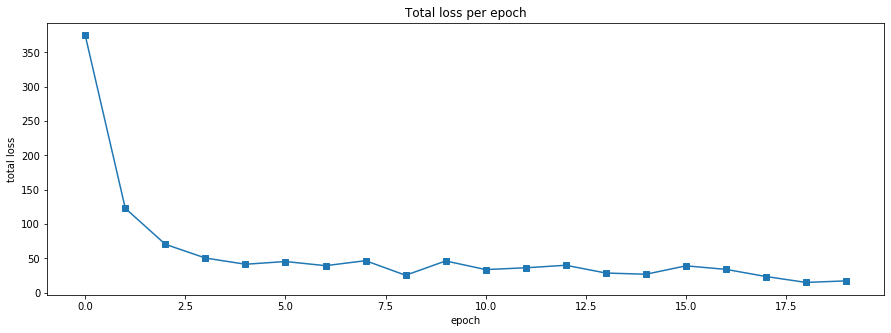

In [74]:
plt.figure(figsize=(15,5))
plt.plot(loss_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('total loss')
plt.title('Total loss per epoch')
plt.show()

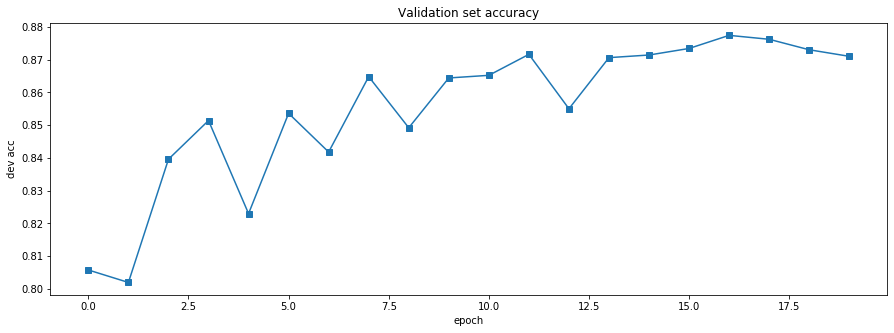

In [75]:
plt.figure(figsize=(15,5))
plt.plot(dev_acc_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('dev acc')
plt.title('Validation set accuracy')
plt.show()

In [76]:
textcnn_random = TextCNN(embed_dim, pretrained_embed, filter_size, filter_channels,
                         out_dim, dropout_rate, freeze=freeze, random_embed=random_embed,
                         vocab_size=vocab_size).to(device)
textcnn_random.load_state_dict(torch.load('textcnn_random.pt'))
print(f"Test set acc: {eva(textcnn_random, test_iter):.2%}")

Test set acc: 87.12%


## 6.5 比较

在测试集上的准确率为：

- TextCNN+GloVe Freeze: 87.12%
- TextCNN+GloVe UnFreeze: 88.40%
- TextCNN+Random: 87.12%

# 七、分类器3:TextRNN

## 7.1 模型

In [77]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional,
                 dropout_rate):
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, bidirectional=bidirectional,
                           dropout=dropout_rate)
            
    def forward(self, x, length):
        packed_x = nn.utils.rnn.pack_padded_sequence(x, length)
        packed_output, (hidden, cell) = self.rnn(packed_x)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        return hidden, output

In [78]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional,
                dropout_rate):
        super(GRU, self).__init__()
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, bidirectional=bidirectional,
                          dropout=dropout_rate)
            
    def forward(self, x, length):
        packed_x = nn.utils.rnn.pack_padded_sequence(x, length)
        packed_output, hidden = self.rnn(packed_x)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        return hidden, output

In [79]:
class TextRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, num_layers, bidirectional, out_dim,
                 dropout_rate, pretrained_embed, use_gru=False, freeze=True,
                 random_embed=False, vocab_size=None):
        super(TextRNN, self).__init__()
        if random_embed:
            self.embed = nn.Embedding(vocab_size, embed_size)
        else:
            self.embed = nn.Embedding.from_pretrained(pretrained_embed, freeze=True)
        if use_gru:
            self.rnn = GRU(embed_size, hidden_size, num_layers, bidirectional,
                           dropout_rate)
        else:
            self.rnn = LSTM(embed_size, hidden_size, num_layers, bidirectional,
                            dropout_rate)
        self.proj = nn.Linear(2*hidden_size, out_dim)
        self.dropout = nn.Dropout(p=dropout_rate)
    
    def forward(self, x):
        text, text_length = x # text: [seq_len, bs]
        text = text.permute(1, 0) # text: [bs, seq_len]
        embed_x = self.embed(text) # embed_x: [bs, seq_len, embed_dim]
        embed_x = embed_x.permute(1, 0, 2) # embed_x: [seq_len, bs, embed_dim]
        hidden, _ = self.rnn(embed_x, text_length) # hidden: [2*num_layers, bs, hidden_size]
        hidden = torch.cat((hidden[-1,:,:], hidden[-2,:,:]), dim=1)
        return self.proj(self.dropout(hidden))

## 7.1 LSTM+GloVe Freeze

In [80]:
embed_size = 300
hidden_size = 300
num_layers = 2
bidirectional = True
out_dim = 2
dropout_rate = 0.2
pretrained_embed = text_field.vocab.vectors
lr = 0.001
num_epoch = 20
freeze = True
use_gru = False
random_embed = False
vocab_size = len(text_field.vocab.stoi)
out_model_file = 'textrnn_lstm_freeze.pt'

textrnn_lstm_freeze = TextRNN(embed_size, hidden_size, num_layers, bidirectional, out_dim,
                              dropout_rate, pretrained_embed, use_gru=use_gru, freeze=freeze,
                              random_embed=random_embed, vocab_size=None).to(device)
opt = torch.optim.Adam(textrnn_lstm_freeze.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
print("Training begin!")
loss_list, dev_acc_list = train_fun(textrnn_lstm_freeze, train_iter, valid_iter, num_epoch, opt, criterion,
                                    eva, out_model_file)

Training begin!
Epoch: 1/20. Total loss: 177.527. Validation Set Acc: 82.840%.
Epoch: 2/20. Total loss: 147.829. Validation Set Acc: 85.780%.
Epoch: 3/20. Total loss: 119.418. Validation Set Acc: 87.740%.
Epoch: 4/20. Total loss: 103.325. Validation Set Acc: 87.240%.
Epoch: 5/20. Total loss: 87.472. Validation Set Acc: 88.280%.
Epoch: 6/20. Total loss: 72.477. Validation Set Acc: 88.300%.
Epoch: 7/20. Total loss: 53.538. Validation Set Acc: 88.380%.
Epoch: 8/20. Total loss: 37.570. Validation Set Acc: 87.780%.
Epoch: 9/20. Total loss: 24.568. Validation Set Acc: 87.660%.
Epoch: 10/20. Total loss: 15.907. Validation Set Acc: 87.280%.
Epoch: 11/20. Total loss: 12.377. Validation Set Acc: 87.460%.
Epoch: 12/20. Total loss: 9.848. Validation Set Acc: 87.120%.
Epoch: 13/20. Total loss: 7.463. Validation Set Acc: 87.580%.
Epoch: 14/20. Total loss: 6.321. Validation Set Acc: 87.840%.
Epoch: 15/20. Total loss: 6.591. Validation Set Acc: 88.040%.
Epoch: 16/20. Total loss: 5.466. Validation Set 

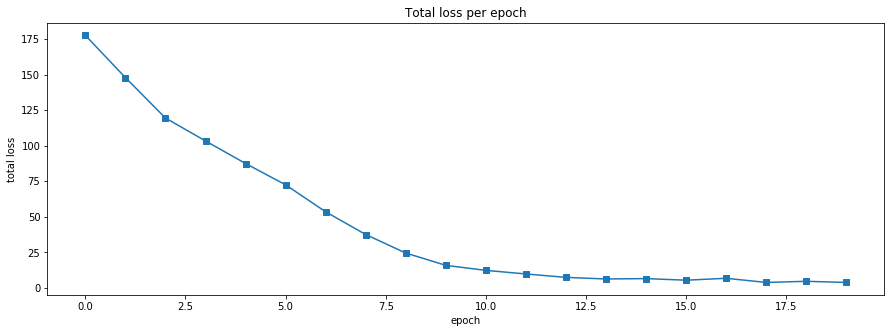

In [81]:
plt.figure(figsize=(15,5))
plt.plot(loss_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('total loss')
plt.title('Total loss per epoch')
plt.show()

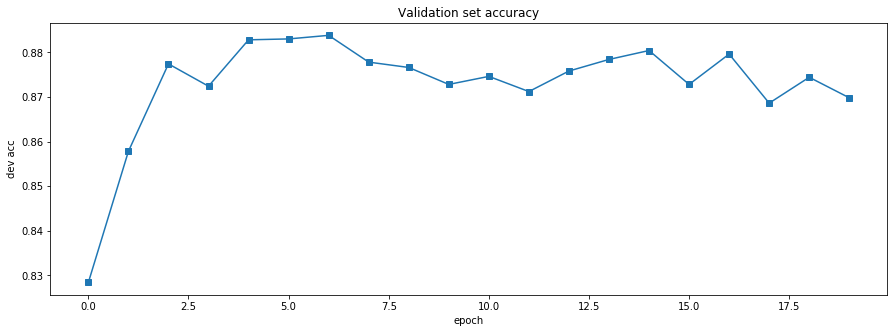

In [82]:
plt.figure(figsize=(15,5))
plt.plot(dev_acc_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('dev acc')
plt.title('Validation set accuracy')
plt.show()

In [83]:
textrnn_lstm_freeze = TextRNN(embed_size, hidden_size, num_layers, bidirectional, out_dim,
                              dropout_rate, pretrained_embed, use_gru=use_gru, freeze=freeze,
                              random_embed=random_embed, vocab_size=None).to(device)
textrnn_lstm_freeze.load_state_dict(torch.load('textrnn_lstm_freeze.pt'))
print(f"Test set acc: {eva(textrnn_lstm_freeze, test_iter):.2%}")

Test set acc: 88.26%


## 7.2 LSTM+GloVe UnFreeze

In [84]:
embed_size = 300
hidden_size = 300
num_layers = 2
bidirectional = True
out_dim = 2
dropout_rate = 0.2
pretrained_embed = text_field.vocab.vectors
lr = 0.001
num_epoch = 20
freeze = False
use_gru = False
random_embed = False
vocab_size = len(text_field.vocab.stoi)
out_model_file = 'textrnn_lstm_unfreeze.pt'

textrnn_lstm_unfreeze = TextRNN(embed_size, hidden_size, num_layers, bidirectional, out_dim,
                               dropout_rate, pretrained_embed, use_gru=use_gru, freeze=freeze,
                               random_embed=random_embed, vocab_size=None).to(device)
opt = torch.optim.Adam(textrnn_lstm_unfreeze.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
print("Training begin!")
loss_list, dev_acc_list = train_fun(textrnn_lstm_unfreeze, train_iter, valid_iter, num_epoch, opt, criterion,
                                    eva, out_model_file)

Training begin!
Epoch: 1/20. Total loss: 191.663. Validation Set Acc: 82.240%.
Epoch: 2/20. Total loss: 143.902. Validation Set Acc: 85.400%.
Epoch: 3/20. Total loss: 117.904. Validation Set Acc: 87.780%.
Epoch: 4/20. Total loss: 103.200. Validation Set Acc: 86.540%.
Epoch: 5/20. Total loss: 87.451. Validation Set Acc: 88.780%.
Epoch: 6/20. Total loss: 69.906. Validation Set Acc: 88.620%.
Epoch: 7/20. Total loss: 51.581. Validation Set Acc: 87.640%.
Epoch: 8/20. Total loss: 32.533. Validation Set Acc: 88.180%.
Epoch: 9/20. Total loss: 22.765. Validation Set Acc: 87.800%.
Epoch: 10/20. Total loss: 14.119. Validation Set Acc: 87.340%.
Epoch: 11/20. Total loss: 11.168. Validation Set Acc: 87.400%.
Epoch: 12/20. Total loss: 10.314. Validation Set Acc: 87.060%.
Epoch: 13/20. Total loss: 7.739. Validation Set Acc: 87.860%.
Epoch: 14/20. Total loss: 5.456. Validation Set Acc: 88.520%.
Epoch: 15/20. Total loss: 7.640. Validation Set Acc: 88.280%.
Epoch: 16/20. Total loss: 4.595. Validation Set

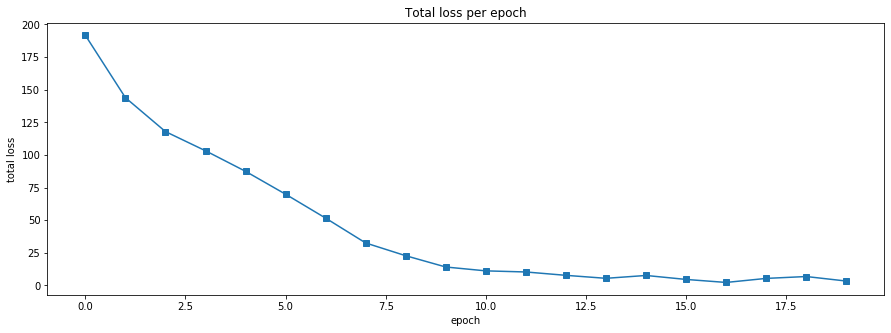

In [85]:
plt.figure(figsize=(15,5))
plt.plot(loss_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('total loss')
plt.title('Total loss per epoch')
plt.show()

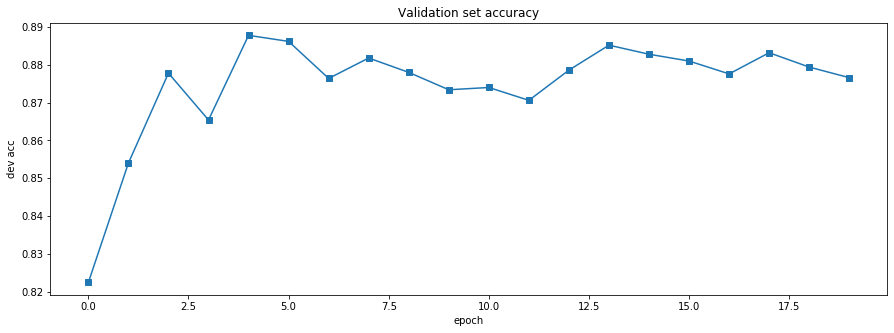

In [86]:
plt.figure(figsize=(15,5))
plt.plot(dev_acc_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('dev acc')
plt.title('Validation set accuracy')
plt.show()

In [87]:
textrnn_lstm_unfreeze = TextRNN(embed_size, hidden_size, num_layers, bidirectional, out_dim,
                               dropout_rate, pretrained_embed, use_gru=use_gru, freeze=freeze,
                               random_embed=random_embed, vocab_size=None).to(device)
textrnn_lstm_unfreeze.load_state_dict(torch.load('textrnn_lstm_unfreeze.pt'))
print(f"Test set acc: {eva(textrnn_lstm_unfreeze, test_iter):.2%}")

Test set acc: 88.15%


## 7.3 LSTM+Random

In [89]:
embed_size = 300
hidden_size = 300
num_layers = 2
bidirectional = True
out_dim = 2
dropout_rate = 0.2
pretrained_embed = text_field.vocab.vectors
lr = 0.001
num_epoch = 20
freeze = False
use_gru = False
random_embed = True
vocab_size = len(text_field.vocab.stoi)
out_model_file = 'textrnn_lstm_random.pt'

textrnn_lstm_random = TextRNN(embed_size, hidden_size, num_layers, bidirectional, out_dim,
                             dropout_rate, pretrained_embed, use_gru=use_gru, freeze=freeze,
                             random_embed=random_embed, vocab_size=vocab_size).to(device)
opt = torch.optim.Adam(textrnn_lstm_random.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
print("Training begin!")
loss_list, dev_acc_list = train_fun(textrnn_lstm_random, train_iter, valid_iter, num_epoch, opt, criterion,
                                    eva, out_model_file)

Training begin!
Epoch: 1/20. Total loss: 201.849. Validation Set Acc: 81.140%.
Epoch: 2/20. Total loss: 117.421. Validation Set Acc: 86.040%.
Epoch: 3/20. Total loss: 61.989. Validation Set Acc: 86.640%.
Epoch: 4/20. Total loss: 23.527. Validation Set Acc: 86.940%.
Epoch: 5/20. Total loss: 11.114. Validation Set Acc: 86.920%.
Epoch: 6/20. Total loss: 5.959. Validation Set Acc: 86.740%.
Epoch: 7/20. Total loss: 6.119. Validation Set Acc: 86.420%.
Epoch: 8/20. Total loss: 5.437. Validation Set Acc: 86.380%.
Epoch: 9/20. Total loss: 4.150. Validation Set Acc: 86.100%.
Epoch: 10/20. Total loss: 5.519. Validation Set Acc: 87.200%.
Epoch: 11/20. Total loss: 3.583. Validation Set Acc: 86.020%.
Epoch: 12/20. Total loss: 4.124. Validation Set Acc: 86.700%.
Epoch: 13/20. Total loss: 0.591. Validation Set Acc: 87.280%.
Epoch: 14/20. Total loss: 0.039. Validation Set Acc: 87.060%.
Epoch: 15/20. Total loss: 0.014. Validation Set Acc: 87.280%.
Epoch: 16/20. Total loss: 0.008. Validation Set Acc: 87.

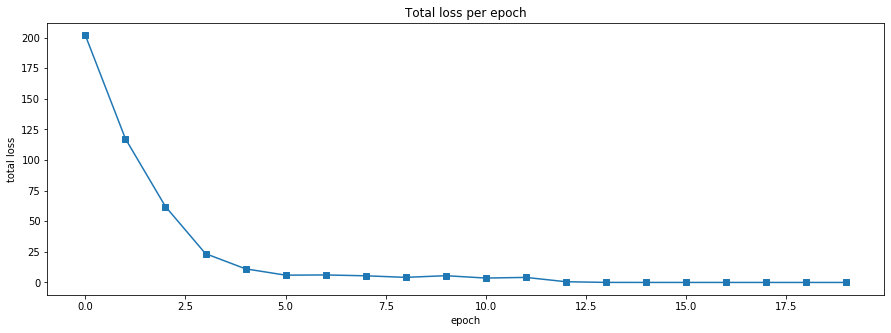

In [90]:
plt.figure(figsize=(15,5))
plt.plot(loss_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('total loss')
plt.title('Total loss per epoch')
plt.show()

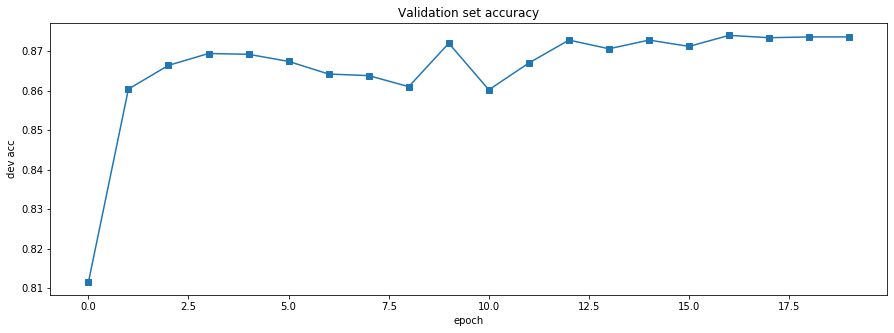

In [91]:
plt.figure(figsize=(15,5))
plt.plot(dev_acc_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('dev acc')
plt.title('Validation set accuracy')
plt.show()

In [94]:
textrnn_lstm_random = TextRNN(embed_size, hidden_size, num_layers, bidirectional, out_dim,
                              dropout_rate, pretrained_embed, use_gru=use_gru, freeze=freeze,
                              random_embed=random_embed, vocab_size=vocab_size).to(device)
textrnn_lstm_random.load_state_dict(torch.load('textrnn_lstm_random.pt'))
print(f"Test set acc: {eva(textrnn_lstm_random, test_iter):.2%}")

Test set acc: 87.12%


## 7.4 GRU+GloVe Freeze

In [95]:
embed_size = 300
hidden_size = 300
num_layers = 2
bidirectional = True
out_dim = 2
dropout_rate = 0.2
pretrained_embed = text_field.vocab.vectors
lr = 0.001
num_epoch = 20
freeze = True
use_gru = True
random_embed = False
vocab_size = len(text_field.vocab.stoi)
out_model_file = 'textrnn_gru_freeze.pt'

textrnn_gru_freeze = TextRNN(embed_size, hidden_size, num_layers, bidirectional, out_dim,
                             dropout_rate, pretrained_embed, use_gru=use_gru, freeze=freeze,
                             random_embed=random_embed, vocab_size=None).to(device)
opt = torch.optim.Adam(textrnn_gru_freeze.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
print("Training begin!")
loss_list, dev_acc_list = train_fun(textrnn_gru_freeze, train_iter, valid_iter, num_epoch, opt, criterion,
                                    eva, out_model_file)

Training begin!
Epoch: 1/20. Total loss: 166.320. Validation Set Acc: 86.960%.
Epoch: 2/20. Total loss: 115.080. Validation Set Acc: 87.160%.
Epoch: 3/20. Total loss: 96.076. Validation Set Acc: 87.920%.
Epoch: 4/20. Total loss: 79.008. Validation Set Acc: 88.060%.
Epoch: 5/20. Total loss: 54.917. Validation Set Acc: 88.820%.
Epoch: 6/20. Total loss: 31.237. Validation Set Acc: 87.040%.
Epoch: 7/20. Total loss: 15.983. Validation Set Acc: 87.780%.
Epoch: 8/20. Total loss: 10.775. Validation Set Acc: 87.340%.
Epoch: 9/20. Total loss: 9.277. Validation Set Acc: 87.440%.
Epoch: 10/20. Total loss: 9.031. Validation Set Acc: 88.040%.
Epoch: 11/20. Total loss: 7.705. Validation Set Acc: 87.980%.
Epoch: 12/20. Total loss: 5.449. Validation Set Acc: 87.620%.
Epoch: 13/20. Total loss: 4.140. Validation Set Acc: 87.460%.
Epoch: 14/20. Total loss: 7.316. Validation Set Acc: 88.120%.
Epoch: 15/20. Total loss: 4.412. Validation Set Acc: 88.120%.
Epoch: 16/20. Total loss: 3.634. Validation Set Acc: 

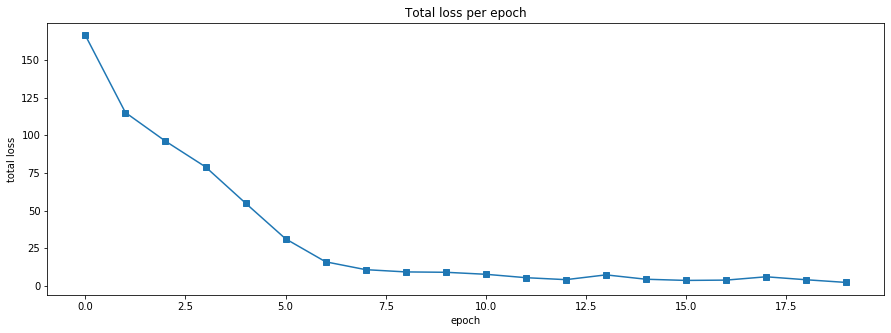

In [96]:
plt.figure(figsize=(15,5))
plt.plot(loss_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('total loss')
plt.title('Total loss per epoch')
plt.show()

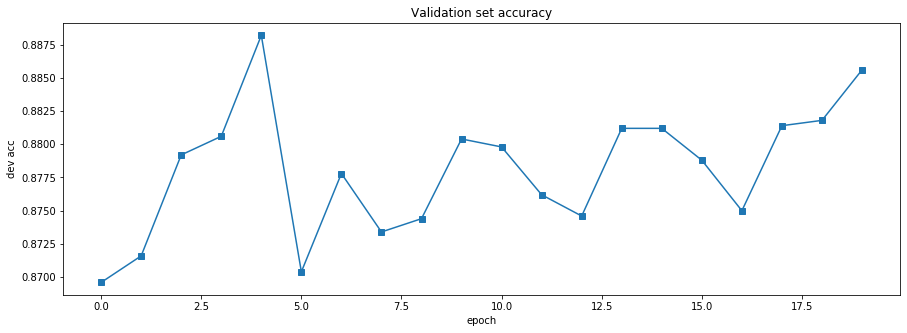

In [97]:
plt.figure(figsize=(15,5))
plt.plot(dev_acc_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('dev acc')
plt.title('Validation set accuracy')
plt.show()

In [98]:
textrnn_gru_freeze = TextRNN(embed_size, hidden_size, num_layers, bidirectional, out_dim,
                             dropout_rate, pretrained_embed, use_gru=use_gru, freeze=freeze,
                             random_embed=random_embed, vocab_size=None).to(device)
textrnn_gru_freeze.load_state_dict(torch.load('textrnn_gru_freeze.pt'))
print(f"Test set acc: {eva(textrnn_gru_freeze, test_iter):.2%}")

Test set acc: 88.59%


## 7.5 GRU+GloVe UnFreeze

In [99]:
embed_size = 300
hidden_size = 300
num_layers = 2
bidirectional = True
out_dim = 2
dropout_rate = 0.2
pretrained_embed = text_field.vocab.vectors
lr = 0.001
num_epoch = 20
freeze = False
use_gru = True
random_embed = False
vocab_size = len(text_field.vocab.stoi)
out_model_file = 'textrnn_gru_unfreeze.pt'

textrnn_gru_unfreeze = TextRNN(embed_size, hidden_size, num_layers, bidirectional, out_dim,
                               dropout_rate, pretrained_embed, use_gru=use_gru, freeze=freeze,
                               random_embed=random_embed, vocab_size=None).to(device)
opt = torch.optim.Adam(textrnn_gru_unfreeze.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
print("Training begin!")
loss_list, dev_acc_list = train_fun(textrnn_gru_unfreeze, train_iter, valid_iter, num_epoch, opt, criterion,
                                    eva, out_model_file)

Training begin!
Epoch: 1/20. Total loss: 160.494. Validation Set Acc: 86.060%.
Epoch: 2/20. Total loss: 115.700. Validation Set Acc: 87.520%.
Epoch: 3/20. Total loss: 99.696. Validation Set Acc: 86.260%.
Epoch: 4/20. Total loss: 78.213. Validation Set Acc: 88.080%.
Epoch: 5/20. Total loss: 55.330. Validation Set Acc: 87.640%.
Epoch: 6/20. Total loss: 30.775. Validation Set Acc: 87.260%.
Epoch: 7/20. Total loss: 16.881. Validation Set Acc: 87.120%.
Epoch: 8/20. Total loss: 11.313. Validation Set Acc: 87.500%.
Epoch: 9/20. Total loss: 8.157. Validation Set Acc: 87.220%.
Epoch: 10/20. Total loss: 7.793. Validation Set Acc: 87.340%.
Epoch: 11/20. Total loss: 7.021. Validation Set Acc: 87.620%.
Epoch: 12/20. Total loss: 4.898. Validation Set Acc: 87.420%.
Epoch: 13/20. Total loss: 6.968. Validation Set Acc: 87.100%.
Epoch: 14/20. Total loss: 7.617. Validation Set Acc: 87.880%.
Epoch: 15/20. Total loss: 5.529. Validation Set Acc: 87.960%.
Epoch: 16/20. Total loss: 3.231. Validation Set Acc: 

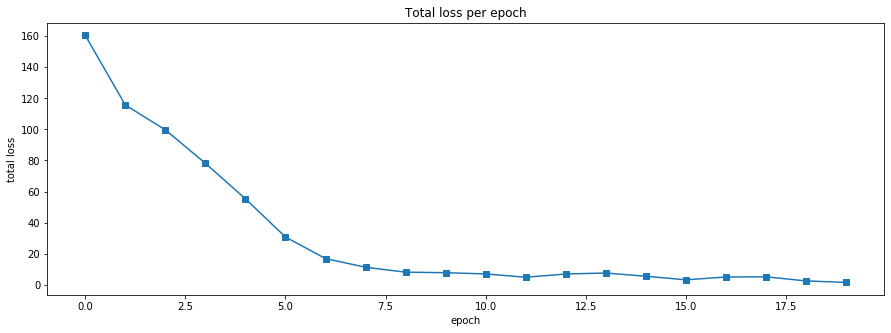

In [100]:
plt.figure(figsize=(15,5))
plt.plot(loss_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('total loss')
plt.title('Total loss per epoch')
plt.show()

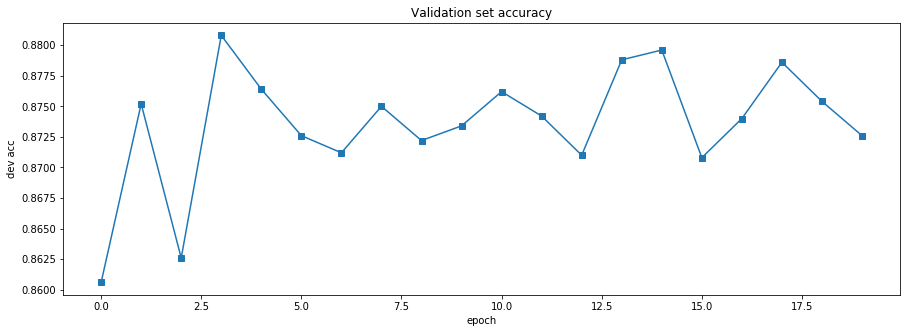

In [101]:
plt.figure(figsize=(15,5))
plt.plot(dev_acc_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('dev acc')
plt.title('Validation set accuracy')
plt.show()

In [102]:
textrnn_gru_unfreeze = TextRNN(embed_size, hidden_size, num_layers, bidirectional, out_dim,
                               dropout_rate, pretrained_embed, use_gru=use_gru, freeze=freeze,
                               random_embed=random_embed, vocab_size=None).to(device)
textrnn_gru_unfreeze.load_state_dict(torch.load('textrnn_gru_unfreeze.pt'))
print(f"Test set acc: {eva(textrnn_gru_unfreeze, test_iter):.2%}")

Test set acc: 88.29%


## 7.6 GRU+Random

In [103]:
embed_size = 300
hidden_size = 300
num_layers = 2
bidirectional = True
out_dim = 2
dropout_rate = 0.2
pretrained_embed = text_field.vocab.vectors
lr = 0.001
num_epoch = 20
freeze = False
use_gru = True
random_embed = True
vocab_size = len(text_field.vocab.stoi)
out_model_file = 'textrnn_gru_random.pt'

textrnn_gru_random = TextRNN(embed_size, hidden_size, num_layers, bidirectional, out_dim,
                             dropout_rate, pretrained_embed, use_gru=use_gru, freeze=freeze,
                             random_embed=random_embed, vocab_size=vocab_size).to(device)
opt = torch.optim.Adam(textrnn_gru_random.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
print("Training begin!")
loss_list, dev_acc_list = train_fun(textrnn_gru_random, train_iter, valid_iter, num_epoch, opt, criterion,
                                    eva, out_model_file)

Training begin!
Epoch: 1/20. Total loss: 187.860. Validation Set Acc: 83.860%.
Epoch: 2/20. Total loss: 100.165. Validation Set Acc: 86.980%.
Epoch: 3/20. Total loss: 49.479. Validation Set Acc: 87.660%.
Epoch: 4/20. Total loss: 20.668. Validation Set Acc: 86.820%.
Epoch: 5/20. Total loss: 9.472. Validation Set Acc: 86.500%.
Epoch: 6/20. Total loss: 7.199. Validation Set Acc: 86.320%.
Epoch: 7/20. Total loss: 6.617. Validation Set Acc: 86.420%.
Epoch: 8/20. Total loss: 4.370. Validation Set Acc: 86.820%.
Epoch: 9/20. Total loss: 4.479. Validation Set Acc: 86.500%.
Epoch: 10/20. Total loss: 4.585. Validation Set Acc: 86.540%.
Epoch: 11/20. Total loss: 2.615. Validation Set Acc: 87.040%.
Epoch: 12/20. Total loss: 5.015. Validation Set Acc: 87.080%.
Epoch: 13/20. Total loss: 3.595. Validation Set Acc: 87.100%.
Epoch: 14/20. Total loss: 2.072. Validation Set Acc: 87.220%.
Epoch: 15/20. Total loss: 2.650. Validation Set Acc: 87.000%.
Epoch: 16/20. Total loss: 3.275. Validation Set Acc: 87.1

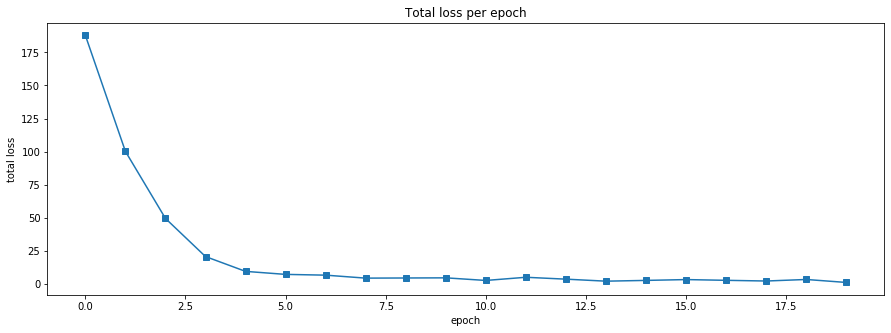

In [104]:
plt.figure(figsize=(15,5))
plt.plot(loss_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('total loss')
plt.title('Total loss per epoch')
plt.show()

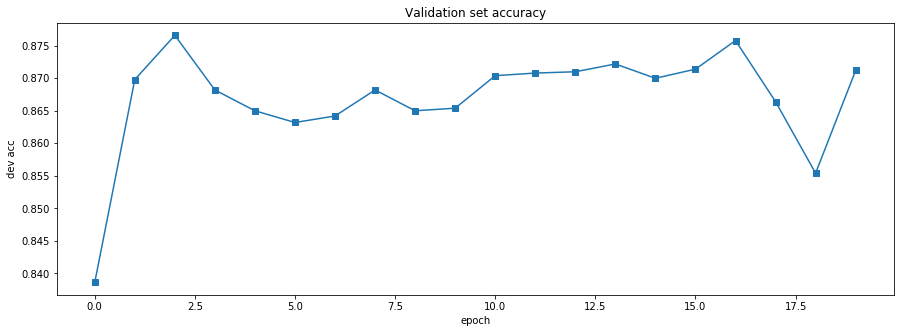

In [105]:
plt.figure(figsize=(15,5))
plt.plot(dev_acc_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('dev acc')
plt.title('Validation set accuracy')
plt.show()

In [106]:
textrnn_gru_random = TextRNN(embed_size, hidden_size, num_layers, bidirectional, out_dim,
                             dropout_rate, pretrained_embed, use_gru=use_gru, freeze=freeze,
                             random_embed=random_embed, vocab_size=vocab_size).to(device)
textrnn_gru_random.load_state_dict(torch.load('textrnn_gru_random.pt'))
print(f"Test set acc: {eva(textrnn_gru_random, test_iter):.2%}")

Test set acc: 87.38%


## 7.7 比较

在测试集上的准确率为：

- TextRNN+LSTM+GloVe Freeze: 88.26%
- TextRNN+LSTM+GloVe UnFreeze: 88.15%
- TextRNN+LSTM+Random: 87.12%
- TextRNN+GRU+GloVe Freeze: 88.59%
- TextRNN+GRU+GloVe UnFreeze: 88.29%
- TextRNN+GRU+Random: 87.38%

# 八、分类器4:TextRCNN

## 8.1 模型

In [107]:
class TextRCNN(nn.Module):
    def __init__(self, embed_size, hidden_size, num_layers, bidirectional,
                 out_dim, dropout_rate, pretrained_embed, freeze=freeze,
                 vocab_size=None, random_embed=False):
        super(TextRCNN, self).__init__()
        if random_embed:
            self.embed = nn.Embedding(vocab_size, embed_size)
        else:
            self.embed = nn.Embedding.from_pretrained(pretrained_embed, freeze=freeze)
        self.rnn = nn.GRU(input_size=embed_size, hidden_size=hidden_size,
                          num_layers=num_layers, bidirectional=bidirectional,
                          dropout=dropout_rate)
        self.proj1 = nn.Linear(2 * hidden_size + embed_size, 2 * hidden_size)
        self.tanh = nn.Tanh()
        self.proj2 = nn.Linear(2 * hidden_size, out_dim)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.init_params()
    
    def init_params(self):
        nn.init.xavier_uniform_(self.proj1.weight.data)
        nn.init.xavier_uniform_(self.proj2.weight.data)
        nn.init.constant_(self.proj1.bias.data, 0)
        nn.init.constant_(self.proj2.bias.data, 0)
    
    def forward(self, x):
        text, _ = x # text: [seq_len, bs]
        embed_x = self.embed(text) # emebd_x: [seq_len, bs, embed_dim]
        output, _ = self.rnn(embed_x) # output: [seq_len, bs, 2*hidden_size]
        embed_x, output = embed_x.permute(1, 0, 2), output.permute(1, 0, 2) # [bs, seq_len, 2*hidden_size]
        y = torch.cat((output, embed_x), 2) # y: [bs, seq_len, 2*hidden_size+embed_dim]
        z = self.tanh(self.proj1(y)) # z: [bs, seq_len, 2*hidden_size]
        z = z.permute(0, 2, 1) # z: [bs, 2*hidden_size, seq_len]
        z = torch.max_pool1d(z, z.shape[-1]).squeeze(-1) # z: [bs, 2*hidden_size]
        return self.proj2(self.dropout(z))

## 8.2 TextRCNN+GloVe Unfreeze

In [108]:
embed_size = 300
hidden_size = 300
num_layers = 2
bidirectional = True
out_dim = 2
dropout_rate = 0.2
pretrained_embed = text_field.vocab.vectors
lr = 0.001
num_epoch = 20
out_model_file = 'textrcnn.pt'

textrcnn = TextRCNN(embed_size, hidden_size, num_layers, bidirectional, out_dim,
                   dropout_rate, pretrained_embed, freeze=False).to(device)
opt = torch.optim.Adam(textrcnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
print("Training begin!")
loss_list, dev_acc_list = train_fun(textrcnn, train_iter, valid_iter, num_epoch, opt, criterion,
                                    eva, out_model_file)

Training begin!
Epoch: 1/20. Total loss: 143.528. Validation Set Acc: 89.240%.
Epoch: 2/20. Total loss: 62.500. Validation Set Acc: 89.960%.
Epoch: 3/20. Total loss: 12.907. Validation Set Acc: 87.740%.
Epoch: 4/20. Total loss: 1.797. Validation Set Acc: 88.080%.
Epoch: 5/20. Total loss: 1.041. Validation Set Acc: 86.520%.
Epoch: 6/20. Total loss: 0.367. Validation Set Acc: 87.820%.
Epoch: 7/20. Total loss: 1.793. Validation Set Acc: 87.540%.
Epoch: 8/20. Total loss: 2.437. Validation Set Acc: 86.320%.
Epoch: 9/20. Total loss: 1.890. Validation Set Acc: 86.160%.
Epoch: 10/20. Total loss: 1.304. Validation Set Acc: 87.320%.
Epoch: 11/20. Total loss: 3.219. Validation Set Acc: 84.600%.
Epoch: 12/20. Total loss: 3.618. Validation Set Acc: 85.060%.
Epoch: 13/20. Total loss: 0.732. Validation Set Acc: 86.400%.
Epoch: 14/20. Total loss: 0.125. Validation Set Acc: 83.520%.
Epoch: 15/20. Total loss: 1.520. Validation Set Acc: 86.220%.
Epoch: 16/20. Total loss: 0.973. Validation Set Acc: 86.140

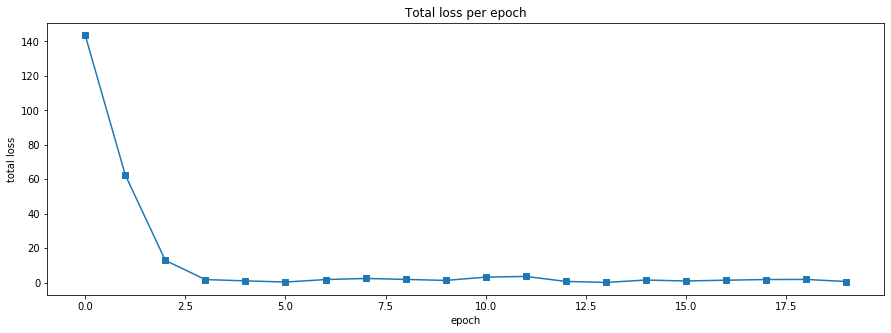

In [109]:
plt.figure(figsize=(15,5))
plt.plot(loss_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('total loss')
plt.title('Total loss per epoch')
plt.show()

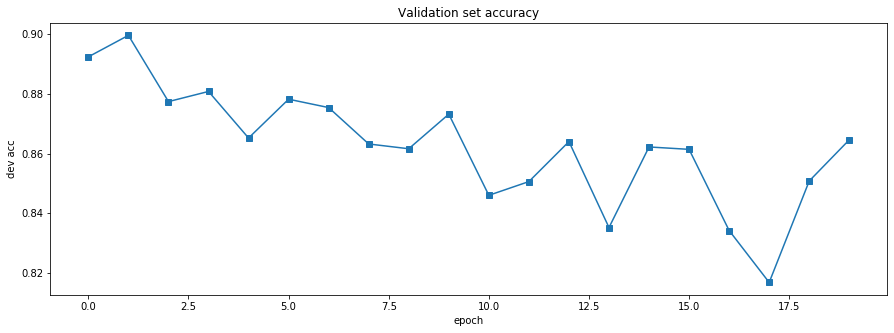

In [110]:
plt.figure(figsize=(15,5))
plt.plot(dev_acc_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('dev acc')
plt.title('Validation set accuracy')
plt.show()

In [111]:
textrcnn = TextRCNN(embed_size, hidden_size, num_layers, bidirectional, out_dim,
                   dropout_rate, pretrained_embed, freeze=False).to(device)
textrcnn.load_state_dict(torch.load('textrcnn.pt'))
print(f"Test set acc: {eva(textrcnn, test_iter):.2%}")

Test set acc: 89.80%


# 九、分类器5:TextHAN (GRU+Attention)

In [112]:
import torch.nn as nn

class TextHAN(nn.Module):
    def __init__(self, embed_size, hidden_size, num_layers, bidirectional, out_dim,
                 dropout_rate, pretrained_embed):
        super(TextHAN, self).__init__()
        self.embed = nn.Embedding.from_pretrained(pretrained_embed, freeze=False)
        self.rnn = nn.GRU(input_size=embed_size, hidden_size=hidden_size,
                          num_layers=num_layers, bidirectional=bidirectional,
                          dropout=dropout_rate)
        self.proj1 = nn.Linear(2 * hidden_size, 2 * hidden_size)
        self.tanh = nn.Tanh()
        self.u = nn.Parameter(torch.Tensor(2 * hidden_size, 1))
        self.proj2 = nn.Linear(2 * hidden_size, out_dim)
        self.init_params()

    def init_params(self):
        nn.init.xavier_uniform_(self.proj1.weight.data)
        nn.init.xavier_uniform_(self.proj2.weight.data)
        nn.init.constant_(self.proj1.bias.data, 0.1)
        nn.init.constant_(self.proj2.bias.data, 0.1)
        nn.init.uniform_(self.u, -0.1, 0.1)
    
    def forward(self, x):
        text, _ = x # text: [seq_len, bs]
        embed_x = self.embed(text) # embed_x: [seq_len, bs, embed_dim]
        rnn_x, _ = self.rnn(embed_x) # rnn_x: [seq_len, bs, hidden_size * 2]
        rnn_x = rnn_x.permute(1, 0, 2) # rnn_x: [bs, seq_len, hidden_size * 2]
        ut = self.tanh(self.proj1(rnn_x)) # ut: [bs, seq_len, hidden_size * 2]
        alpha = torch.softmax(torch.matmul(ut, self.u), dim=1) # alpha: [bs, seq_len, 1]
        s = torch.sum(alpha * rnn_x, dim=1) # s: [bs, hidden*2]
        return self.proj2(s)

In [114]:
embed_size = 300
hidden_size = 300
num_layers = 2
bidirectional = True
out_dim = 2
dropout_rate = 0.2
pretrained_embed = text_field.vocab.vectors
lr = 0.001
num_epoch = 20
out_model_file = 'texthan.pt'

texthan = TextHAN(embed_size, hidden_size, num_layers, bidirectional, out_dim,
                  dropout_rate, pretrained_embed).to(device)
opt = torch.optim.Adam(texthan.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
print("Training begin!")
loss_list = train_fun(texthan, train_iter, valid_iter, num_epoch, opt, criterion,
                      eva, out_model_file)

Training begin!
Epoch: 1/20. Total loss: 172.824. Validation Set Acc: 87.980%.
Epoch: 2/20. Total loss: 71.094. Validation Set Acc: 88.740%.
Epoch: 3/20. Total loss: 15.462. Validation Set Acc: 88.440%.
Epoch: 4/20. Total loss: 2.276. Validation Set Acc: 87.240%.
Epoch: 5/20. Total loss: 3.108. Validation Set Acc: 87.500%.
Epoch: 6/20. Total loss: 1.865. Validation Set Acc: 87.240%.
Epoch: 7/20. Total loss: 1.516. Validation Set Acc: 87.060%.
Epoch: 8/20. Total loss: 0.628. Validation Set Acc: 86.300%.
Epoch: 9/20. Total loss: 0.142. Validation Set Acc: 86.960%.
Epoch: 10/20. Total loss: 0.024. Validation Set Acc: 87.080%.
Epoch: 11/20. Total loss: 0.025. Validation Set Acc: 86.920%.
Epoch: 12/20. Total loss: 0.004. Validation Set Acc: 87.120%.
Epoch: 13/20. Total loss: 0.001. Validation Set Acc: 87.140%.
Epoch: 14/20. Total loss: 0.000. Validation Set Acc: 87.180%.
Epoch: 15/20. Total loss: 0.000. Validation Set Acc: 87.080%.
Epoch: 16/20. Total loss: 0.000. Validation Set Acc: 87.200

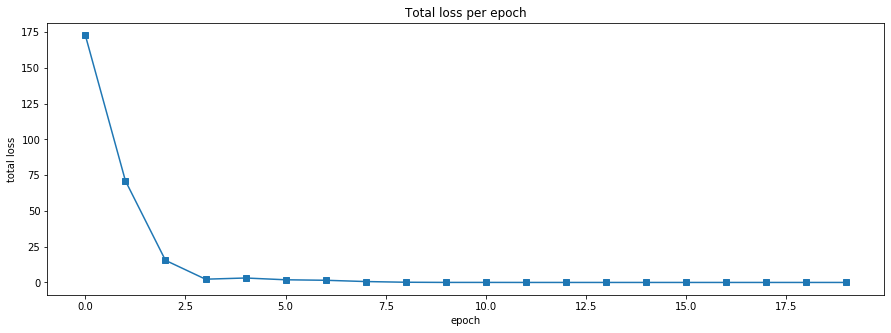

In [118]:
plt.figure(figsize=(15,5))
plt.plot(loss_list[0], marker='s')
plt.xlabel('epoch')
plt.ylabel('total loss')
plt.title('Total loss per epoch')
plt.show()

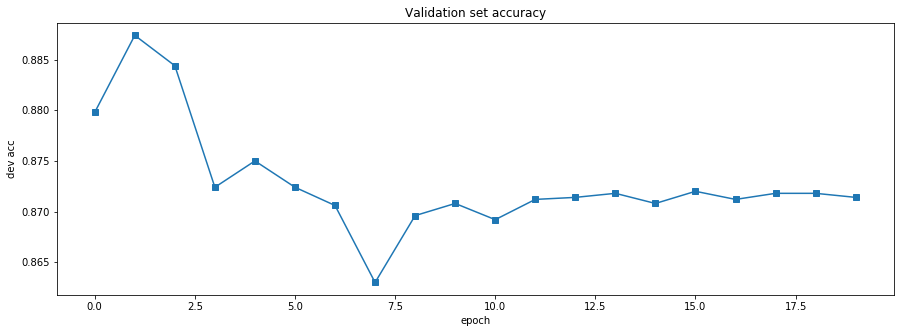

In [119]:
plt.figure(figsize=(15,5))
plt.plot(loss_list[1], marker='s')
plt.xlabel('epoch')
plt.ylabel('dev acc')
plt.title('Validation set accuracy')
plt.show()

In [117]:
texthan = TextHAN(embed_size, hidden_size, num_layers, bidirectional, out_dim,
                  dropout_rate, pretrained_embed).to(device)
texthan.load_state_dict(torch.load('texthan.pt'))
print(f"Test set acc: {eva(texthan, test_iter):.2%}")

Test set acc: 89.16%


# 总结

在该项目中实现了5种文本分类模型，测试集上分类的准确率分别为：

**TextFNN:**
- TextFNN+GloVe Freeze: 77.22%
- TextFNN+GloVe UnFreeze: 84.84%
- TextFNN+Random: 49.90%

**TextCNN:**
- TextCNN+GloVe Freeze: 87.12%
- TextCNN+GloVe UnFreeze: 88.40%
- TextCNN+Random: 87.12%

**TextRNN:**
- TextRNN+LSTM+GloVe Freeze: 88.26%
- TextRNN+LSTM+GloVe UnFreeze: 88.15%
- TextRNN+LSTM+Random: 87.12%
- TextRNN+GRU+GloVe Freeze: 88.59%
- TextRNN+GRU+GloVe UnFreeze: 88.29%
- TextRNN+GRU+Random: 87.38%

**TextRCNN:**
- TextRCNN+GRU+GloVe UnFreeze: 89.80%

**TextHAN:**
- TextHAN+GRU+GloVe Unfreeze: 89.16%